In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag

In [3]:
from iam import IAM, features_binary, alphabet, corpus, FeatureLayer, feature_count, Connection

In [4]:
iam = IAM()

# Present the ambiguous input

We need to present features consistent with both 'WORK' and 'WORR'

Features that are both in K and R

In [5]:
rk_common_features = [min(K_f, K_r) for (K_f, K_r) in zip(features_binary['K'], features_binary['R'])]
rk_common_features

[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

All features

In [6]:
ambiguous_input = np.array([
    features_binary['W'],
    features_binary['O'],
    features_binary['R'],
    rk_common_features
])
ambiguous_input

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

In [7]:
def present_ambiguous_input():
    iam.feature_layer.activations = ambiguous_input.astype(float)

# Test

In [8]:
def get_letter_activation(position, letter):
    return iam.letter_layer.activations[position, alphabet.index(letter)]

In [9]:
def get_word_activation(word):
    word_index = corpus.word.tolist().index(word.lower())
    return iam.word_layer.activations[word_index]

In [10]:
def take_snapshot():
    for letter, activation_list in letter_activations_history.items():
        activation_list.append(get_letter_activation(position=3, letter=letter))
        
    for word, activation_list in word_activations_history.items():
        activation_list.append(get_word_activation(word))

In [11]:
letter_activations_history = dict(K=[], R = [], D = [])
word_activations_history = dict(WORK=[], WORD=[], WEAK=[], WEAR=[])

iam.reset_nodes()
present_ambiguous_input()

take_snapshot()
for _ in range(40):
    iam.run_cycle()
    take_snapshot()

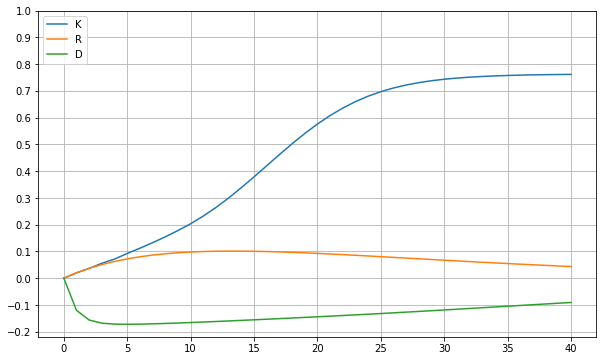

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(letter_activations_history.values())).T)
plt.legend(list(letter_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_letter-activation-plots.png)

- In our simulation, "D" gets uninhibited, in the article, "D" stayst at -0.2
- In our simulation, "R" gets a bit activated (~0.1) and then decays towards 0, in the article, "R" grows steadily towards ~0.35

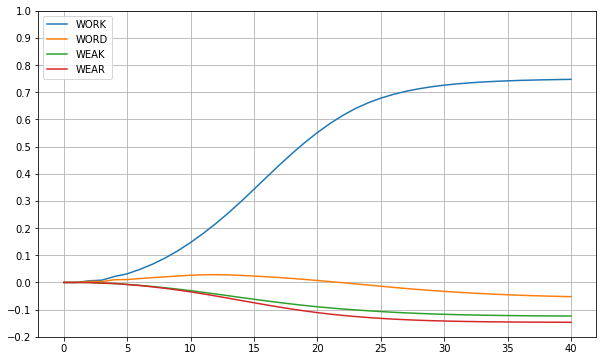

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(word_activations_history.values())).T)
plt.legend(list(word_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_word-activation-plots.png)

- "WORD" get less activate at the peak (~0.03) than in the article (~0.1).
- "WEAK" and "WEAR" plateau later in our simulation.

# Absence detectors

There are two main differences between our implementation and the one from the article:
- we don't have absence detectors,
- word resting levels do not depend on the frequency.

More likely, it is the absence detectors that drive the difference in letter activations.
There are fewer feature nodes to excite "R" (absence detectors of features absent in both "R" and "K") and inhibit "D" (features absent in "R" and "K" but present in "D").

In [14]:
class AbsenceDetectorLayer(FeatureLayer):
    def present_word(self, word):
        """Show a word to the model"""
        features_absent = 1 - np.array([features_binary[letter] for letter in word])
        # Set features absent in the word to the maximum activation
        self.activations = self.maximum_activation * features_absent

class IAMWithAbsenceDetectors(IAM):
    def __init__(self):
        super().__init__()
        
        self.absence_detector_layer = AbsenceDetectorLayer(
            shape=(self.position_count, feature_count),
            resting_activation=0,
            minimum_activation=self.m,
            maximum_activation=self.M,
            decay_rate=self.theta)
        
        self._layers.append(self.absence_detector_layer)
        
        # Feature-to-letter-connections
        # Each detected absent feature excites letters that don't contain this feature and inhibits those that do
        is_excitatory = 1 - np.array([features_binary[letter]
                                      for letter 
                                      in sorted(features_binary.keys())]).T
        # For one letter
        feature_to_letter_excitatory = 0.005
        feature_to_letter_inhibitory = 0.15
        absence_detector_to_letter_weights_1 = np.where(
            is_excitatory,
            feature_to_letter_excitatory,
            - feature_to_letter_inhibitory
        )
        # For all letters
        absence_detector_to_letter_weights = block_diag(
            *[absence_detector_to_letter_weights_1 for _ in range(4)])
        absence_detector_to_letter_connection = Connection(
            layer_from=self.absence_detector_layer,
            layer_to=self.letter_layer,
            weights=absence_detector_to_letter_weights
        )
        
    def present_word(word):
        # Feature presence layer
        super().present_word(word)
        self.absence_detector_layer.present_word(word)
        
    def get_letter_activation(self, position, letter):
        return self.letter_layer.activations[position, alphabet.index(letter)]
    
    def get_word_activation(self, word):
        word_index = corpus.word.tolist().index(word.lower())
        return self.word_layer.activations[word_index]

In [15]:
iam_with_absence_detectors = IAMWithAbsenceDetectors()

In [16]:
rk_common_absent_features = [1 - max(K_f, K_r) for (K_f, K_r) in zip(features_binary['K'], features_binary['R'])]
rk_common_absent_features

[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]

In [17]:
ambiguous_input_present_features = np.array([
    features_binary['W'],
    features_binary['O'],
    features_binary['R'],
    rk_common_features
])
ambiguous_input_present_features

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

In [18]:
ambiguous_input_absent_features = np.array([
    1 - np.array(features_binary['W']),
    1 - np.array(features_binary['O']),
    1 - np.array(features_binary['R']),
    rk_common_absent_features
])
ambiguous_input_absent_features

array([[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]])

In [19]:
def present_ambiguous_input_2():
    iam_with_absence_detectors.feature_layer.activations = ambiguous_input_present_features.astype(float)
    iam_with_absence_detectors.absence_detector_layer.activations = ambiguous_input_absent_features.astype(float)

In [20]:
def take_snapshot_2():
    for letter, activation_list in letter_activations_history.items():
        activation_list.append(iam_with_absence_detectors.get_letter_activation(position=3, letter=letter))
        
    for word, activation_list in word_activations_history.items():
        activation_list.append(iam_with_absence_detectors.get_word_activation(word))

In [21]:
letter_activations_history = dict(K=[], R = [], D = [])
word_activations_history = dict(WORK=[], WORD=[], WEAK=[], WEAR=[])

iam_with_absence_detectors.reset_nodes()
present_ambiguous_input_2()

take_snapshot_2()
for _ in range(40):
    iam_with_absence_detectors.run_cycle()
    take_snapshot_2()

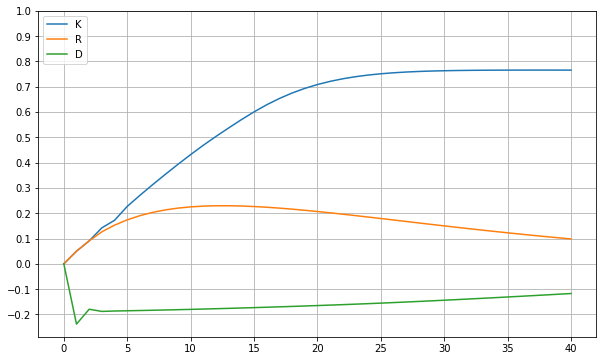

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(letter_activations_history.values())).T)
plt.legend(list(letter_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_letter-activation-plots.png)

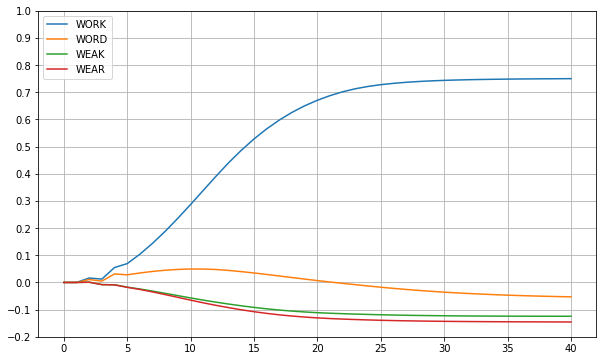

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(word_activations_history.values())).T)
plt.legend(list(word_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_word-activation-plots.png)